In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_embed, reg_nn_lmm, reg_nn_menet
from lmmnn.simulation import Count

import tensorflow.keras.backend as K

In [3]:
# Note: pa_final.csv is the result of an ETL process described in Pierce et. al. (2020), see our paper
# after downloading the UKB relevant data.

# Due to a TF bug there seems to be a memory leakage between LMMNN and other methods when run together,
# and those other methods suffer in performance. Consider running LMMNNN separately.

ukb = pd.read_csv('../data/pa_final.csv')
ukb.drop(['center', 'job_orig', 'center_orig'], axis=1, inplace=True)

In [4]:
ukb.head()

,gender,enmo,job,heavy_work,walking_work,sedentary_work,mvpa,walking_pleasure,strenuous_sport,other_act,...,getting_cycle,getting_other,getting_transport,getting_walk,commuting_cycle,commuting_other,commuting_transport,commuting_walk,sleep,bmi
0,0,27.17,0,0.00000,0.000000,5.957686,4.824879,2.983153,0.000000,2.460809,...,0,0,0,0,0,0,0,1,7,23.4959
1,1,20.09,1,0.00000,4.330733,5.420535,2.772589,1.613003,0.000000,0.000000,...,0,0,0,0,0,1,0,0,7,31.8077
2,1,35.82,2,0.00000,0.000000,4.928288,3.945734,2.983153,2.040756,1.613003,...,0,0,0,0,0,0,0,0,7,24.6918
3,0,22.82,3,0.00000,0.000000,0.000000,4.242354,0.000000,0.000000,0.000000,...,0,0,0,1,0,1,0,0,7,19.7777
4,0,31.54,4,3.99951,0.000000,5.085831,3.433987,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,1,6,33.7768


In [5]:
ukb = ukb[ukb['enmo'] < 80]
ukb.index = range(ukb.shape[0])

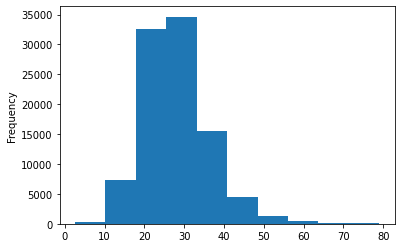

In [6]:
ukb['enmo'].plot(kind='hist')
plt.show()

In [7]:
qs = [len(ukb['job'].unique())]

In [8]:
ukb.shape

(96629, 24)

In [9]:
# if using our reg_lmm call RE col 'z0', 'z1' etc
ukb.rename({'job': 'z0'}, axis=1, inplace=True)

In [ ]:
x_cols = [col for col in ukb.columns if col not in ['enmo', 'z0']]
batch = 100
epochs = 500
patience = 10
q_spatial = None
n_neurons = [10, 5]
dropout = None
activation = 'relu'
Z_non_linear = False
Z_embed_dim_pct = 10
mode = 'intercepts'
n_sig2bs = 1
n_sig2bs_spatial = 0
est_cors = []
dist_matrix = None
time2measure_dict = None
spatial_embed_neurons = None
resultion = None
verbose = True
log_params = False
idx = None

In [ ]:
x_cols

In [ ]:
def reg_nn(X_train, X_test, y_train, y_test, reg_type):
    start = time.time()
    if reg_type == 'ohe':
        y_pred, sigmas, rhos, weibull, n_epochs = reg_nn_ohe_or_ignore(
            X_train, X_test, y_train, y_test, qs, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode, n_sig2bs, n_sig2bs_spatial, est_cors, verbose)
    elif reg_type == 'lmm':
        y_pred, sigmas, rhos, weibull, n_epochs = reg_nn_lmm(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode,
            n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons, verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)
    elif reg_type == 'ignore':
        y_pred, sigmas, rhos, weibull, n_epochs = reg_nn_ohe_or_ignore(
            X_train, X_test, y_train, y_test, qs, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode, n_sig2bs, n_sig2bs_spatial, est_cors, verbose, ignore_RE=True)
    elif reg_type == 'embed':
        y_pred, sigmas, rhos, weibull, n_epochs = reg_nn_embed(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode, n_sig2bs, n_sig2bs_spatial, est_cors, verbose)
    elif reg_type == 'menet':
        y_pred, sigmas, rhos, weibull, n_epochs = reg_nn_menet(
            X_train, X_test, y_train, y_test, qs[0], x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode, n_sig2bs, n_sig2bs_spatial, est_cors, verbose)
    else:
        raise ValueError(reg_type + 'is an unknown reg_type')
    end = time.time()
    K.clear_session()
    gc.collect()
    mse = np.mean((y_pred - y_test)**2)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.show()
    return mse, sigmas, n_epochs, end - start

In [13]:
res = pd.DataFrame(columns=['experiment', 'exp_type', 'mse', 'sigma_e_est', 'sigma_b_est', 'n_epoch', 'time'])
counter = 0

def iterate_reg_types(X_train, X_test, y_train, y_test):
    global counter
    mse_ohe, _, n_epochs_ohe, time_ohe = reg_nn(X_train, X_test, y_train, y_test, reg_type='ohe')
    print(' finished ohe, mse: %.2f' % (mse_ohe))
    mse_lmm, sigmas, n_epochs_lmm, time_lmm = reg_nn(X_train, X_test, y_train, y_test, reg_type='lmm')
    print(' finished lmmnn, mse: %.2f' % (mse_lmm))
    mse_ig, _, n_epochs_ig, time_ig = reg_nn(X_train, X_test, y_train, y_test, reg_type='ignore')
    print(' finished ignore, mse: %.2f' % (mse_ig))
    mse_em, _, n_epochs_em, time_em = reg_nn(X_train, X_test, y_train, y_test, reg_type='embed')
    print(' finished embed, mse: %.2f' % (mse_em))
    mse_me, sigmas_me, n_epochs_me, time_me = reg_nn(X_train, X_test, y_train, y_test, reg_type='menet')
    print(' finished menet, mse: %.2f' % (mse_me))
    res.loc[next(counter)] = [i, 'ohe', mse_ohe, np.nan, np.nan, n_epochs_ohe, time_ohe]
    res.loc[next(counter)] = [i, 'lmm', mse_lmm, sigmas[0], sigmas[1][0], n_epochs_lmm, time_lmm]
    res.loc[next(counter)] = [i, 'ignore', mse_ig, np.nan, np.nan, n_epochs_ig, time_ig]
    res.loc[next(counter)] = [i, 'embed', mse_em, np.nan, np.nan, n_epochs_em, time_em]
    res.loc[next(counter)] = [i, 'menet', mse_me, sigmas_me[0], np.nan, n_epochs_me, time_me]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
counter = Count().gen()
X, y = ukb.drop('enmo', axis=1), ukb['enmo']
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    print('iteration %d' % i)
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y[train_index], y[test_index]
    scaler = StandardScaler()
    y_train = pd.Series(scaler.fit_transform(y_train.values.reshape(-1, 1)).reshape(X_train.shape[0]))
    y_train.index = X_train.index
    y_test = pd.Series(scaler.transform(y_test.values.reshape(-1, 1)).reshape(X_test.shape[0]))
    y_test.index = X_test.index
    iterate_reg_types(X_train, X_test, y_train, y_test)

In [12]:
res

In [ ]:
res.to_csv('../../results/res_ukb_pa.csv')